## In this Colab we:
1. import list of latin names (ex. emma, justin etc.)
2. prepare & encode data
    - 'emma' : [e  m  m] -> [a]
    - tensor : [5 13 13] -> [1]
    - split train-dev-test
3. initialize trainable embedding matrix C.shape = [vocab_size(27) , **EMB_SIZE** (2)]
    - map any of 27 letter encodings to its embedding. ex. [0] -> [0.1488, 2.1415]
4. Initialize trainable architecture:
    - h = tanh(emb @ hidden_W + hidden_b)
    - logits = h @ out_W + out_b
    - F.cross_entropy(logits, Y_true)
5. train for **N_EPOCHS**

## Result:
- 1
- 2

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [74]:
WINDOW = 3          # how many previous element to consider

# architecture
EMB_SIZE = 10        # dimention of embedding space
HIDDEN_SIZE = 200   # size of hidden layer
# training
LR = 0.1
N_EPOCHS = 100000
BATCH_SIZE = 64

loglossi = []

In [68]:
words = open('../docs/names.txt', 'r').read().splitlines()
print(f'{len(words)=}')
words[:7]

len(words)=32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia']

In [69]:
# build vocab + vLook-Up tables
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(chars + ['.'])

In [70]:
# BUILD DATA given WINDOW size

# example 'emma', WINDOW == 3
# context -> output  |  torch.tensor:
#  [...]  -> 'e'     |  [ 0, 0, 0] -> [5]
#  [..e]  -> 'm'     |  [ 0, 0, 5] -> [13]
#  [.em]  -> 'm'     |  [ 0, 5,13] -> [13]
#  [emm]  -> 'a'     |  [ 5,13,13] -> [1]
#  [mma]  -> '.'     |  [13,13, 1] -> [0]


X, Y = [], []

for w in words:

    context = [0] * WINDOW
    for ch in w + '.' :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        context = context[1:] + [ix] # update context

X = torch.tensor(X)
Y = torch.tensor(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f'Example X[0]: \n{X[0]} -> {Y[0]}\n')
print(f'{X_train.shape=} \n{y_train.shape=}')

Example X[0]: 
tensor([0, 0, 0]) -> 5

X_train.shape=torch.Size([184797, 3]) 
y_train.shape=torch.Size([184797])


### Create simple Embeddings & Neural Network

In [71]:
g = torch.Generator().manual_seed(2147483647)

# BUILD EMBEDDINGS (aka vlook-up)
C = torch.randn((vocab_size,EMB_SIZE))                 # untrained

# BUILD HIDDEN LAYER
hidden_W = torch.randn((WINDOW*EMB_SIZE, HIDDEN_SIZE)) # untrained
hidden_b = torch.randn(HIDDEN_SIZE)                    # untrained

# BUILD OUT LAYER
out_W = torch.randn((HIDDEN_SIZE, vocab_size))         # untrained
out_b = torch.randn(vocab_size)                        # untrained

parameters = [C, hidden_W, hidden_b, out_W, out_b]
for p in parameters:
    p.requires_grad = True

print('Total number of parameters:')
sum(p.nelement() for p in [C, hidden_W, hidden_b, out_W, out_b])

In [77]:
for epoch in range(N_EPOCHS):

    # -------- Forward-pass ---------------

    # mini batch
    ixs = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))

    # train embeddings
    emb = C[X_train[ixs]]                          # (N, 3, 2)
    emb = emb.view(-1, WINDOW*EMB_SIZE) #  concat by tokens -> (N , 6) 

    # train Hidden Layer
    h = torch.tanh(emb @ hidden_W + hidden_b)
    # train Output Layer
    logits = h @ out_W + out_b

    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = - prob[torch.arange(len(X)) , Y].log().mean()
    loss = F.cross_entropy(logits, y_train[ixs])
    loglossi.append(loss.log10().item())
    
    # training
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.01 * p.grad

# train loss
emb = C[X_train]
emb = emb.view(-1, WINDOW*EMB_SIZE)
h = torch.tanh(emb @ hidden_W + hidden_b)
logits = h @ out_W + out_b
loss = F.cross_entropy(logits, y_train)
print(f'Train {loss.data=}')

Train loss.data=tensor(2.0680)


Text(0, 0.5, 'CE LOG-loss')

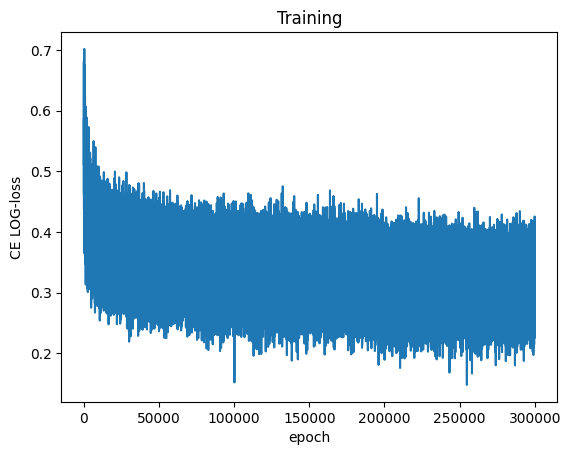

In [79]:
plt.plot(range(len(loglossi)), loglossi)
plt.title('Training')
plt.xlabel('epoch')
plt.ylabel('CE LOG-loss')

In [80]:
if EMB_SIZE == 2:
    plt.scatter(C[:,0].data, C[:,1].data, s=200)
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], 
        ha='center', va='center', color='white')
    plt.grid('sinor')

In [81]:
# dev
emb = C[X_dev]
emb = emb.view(-1, WINDOW*EMB_SIZE)
h = torch.tanh(emb @ hidden_W + hidden_b)
logits = h @ out_W + out_b
loss = F.cross_entropy(logits, y_dev)
print(f'Dev {loss.data=}')

Dev loss.data=tensor(2.1305)
